# Text Vectorization

In this project, I will explore different text vectorization techniques and compare how effective they are in representing textual data.

### List of Contents

1. What is text vectorization?
    * Text Vectorization and Text Embedings
2. Data colection
    * Dataset selection
3. Data exploration 
    * Data visualization
4. Preprocessing text data
5. TF-IDF Vectorization
    * Understanding TF-IDF
    * Implementing TF-IDF with scikit-learn
    * Code example
    * Analyzing most important words per category
6. Word Embeddings: Word2Vec
    * Introduction to Word2Vec

### 1. What is text vectorization?

Text vectorization is the process of *converting text into numerical representations* so that machine learning models and other computational algorithms can process and analyze it. By doing this, operations on sentences become more like math equations, which is something computers can do quickly, and can do well [1].

Many tasks that one would like to perform on textual data like text classification, clustering and search engines can be done much more efficiently with numbers rather than words. Since most algorithms operate on numerical data, vectorizing text is crucial for performing these tasks efficiently.

#### Text Vectorization and Text Embedings

Text vectorization is a much broader term that includes any method that converts text into numerical form. In this regard, **embeddings** are a *specific type* of vectorization. 

Traditional vectorization methods often rely on *sparse vectors*. For example, if we have a vocabulary consisting of four words: (orange, apple, mango, banana), and we want to represent "apple" using one-hot encoding, a possible representation would be [0,1,0,0]. Since the vector size depends on the vocabulary size, if the vocabulary has 100,000 words, each word or document is represented by a 100,000-dimensional vector. However, most of the values in these vectors are zero, leading to inefficiencies in storage and computation (you still have to store and process all those zeroes). Additionally, as dimensionality increases, similarity calculations become less meaningful, making clustering or comparing texts based on meaning more difficult.

A major limitation of these methods is that they lack **context awareness** (each word is treated independently, ignoring relationships between them). For example, "car" and "automobile" would be considered completely different, even though they have similar meanings. Likewise, traditional vectorization methods struggle with **polysemy**, where the same word has multiple meanings depending on context (e.g., "bank" as a financial institution vs. "bank" as the side of a river). 

Examples of traditional vectorization methods include **One-Hot Encoding**, **Count Vectorization**, and **TF-IDF**. 

Text embeddings, on the other hand, represent words or sentences as dense, continuous vectors. Each dimension typically carries meaningful information, enabling the encoding of relationships between words. Lower dimensionality also helps reducing memory usage and speeds up computations.

Examples of embeddings are Word2Vec, GloVe, FastText and BERT embeddings.

### 2. Data colection

#### Dataset selection

For this project, I chose to work with the BBC News dataset, which contains more than 2000 pre-categorized news articles across five topics. This dataset is small enough for rapid experimentation while still being large enough to reflect real-world document processing challenges.

Unlike other text sources that may contain errors and misspellings, this dataset consists of well-formed sentences. This allows the focus to remain on text representation and modeling techniques rather than data cleaning. News articles offer rich, diverse, and formal text and they include domain-specific terminology, which is great for applying word embeddings and vectorization techniques.

In [1]:
import os
import zipfile
import requests

In [7]:
bbc_url = "https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv"
bbc_path = "bbc-text.csv"

In [ ]:
# Download dataset
if not os.path.exists(bbc_path):
    response = requests.get(bbc_url)
    with open(bbc_path, "wb") as f:
        f.write(response.content)
    print("Dataset downloaded successfully.")
else:
    print("Dataset already exists.")

Dataset already exists.


### 3. Data exploration

In [2]:
# Let's load the dataset as a dataframe for easy manipulation

import pandas as pd

df = pd.read_csv("bbc-text.csv")

In [ ]:
print(df.head())  

        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...


The dataframe contains the new's category in the column 'category' and the piece of news itself in the 'text' column 

In [11]:
# Check data types and missing values

print(df.info())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB
None


#### Data visualization

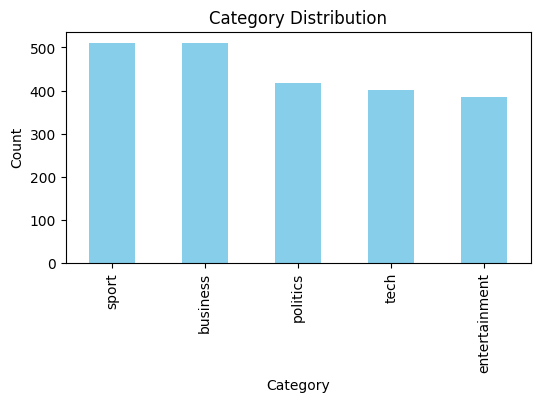

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
df["category"].value_counts().plot(kind="bar", title="Category Distribution", color="skyblue")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


As mentioned before, the dataset does not contain null values, and the news classes are fairly balanced.

### 4. Preprocessing text data

For this crucial step I am going to use the spaCy python package.

In [3]:
import spacy

In [4]:
# Load the English NLP model

nlp = spacy.load("en_core_web_sm")

When you call nlp on a text, spaCy first tokenizes the text to produce a Doc object. Then the Doc objects is processed in different steps (processing pipeline).

The pipeline used by default includes a tagger, a lemmatizer, a parser and an entity recognizer. Each pipeline component returns the processed Doc, which is then passed on to the next component.

The disable keyword argument is used to for disabling pipeline components that are not needed [2]. 

In [5]:
def preprocess_texts(texts):
    processed_texts = []
    for doc in nlp.pipe(texts, disable=["ner", "parser"]):  
        tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]
        processed_texts.append(" ".join(tokens))
    return processed_texts

df["processed_text"] = preprocess_texts(df["text"])


In [21]:
df.head()

,category,text,processed_text
0,tech,tv future in the hands of viewers with home th...,tv future hand viewer home theatre system pl...
1,business,worldcom boss left books alone former worldc...,worldcom boss leave book worldcom boss ber...
2,sport,tigers wary of farrell gamble leicester say ...,tiger wary farrell gamble leicester rush m...
3,sport,yeading face newcastle in fa cup premiership s...,yeade face newcastle fa cup premiership newcas...
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean s raid box office ocean s crime caper ...


### 5. TF-IDF Vectorization

#### Understanding TF-IDF

TF-IDF (Term Frequency - Inverse Document Frequency) is a statistical measure that evaluates how important a word is to a document in a context of a group of documents. 

The TF-IDF score is defined as:

$$
TF-IDF(w) = TF(w) \times IDF(w)
$$

Let's begin defining then what each term means.

* Term frequency (TF): it measures how often a word (w) appears in a document. Calculating this is pretty straight forward:

$$
TF(w) = \frac{\text{Number of times } w \text{ appears in a document}}{\text{Total number of words in the document}}
$$


* Inverse Document Frequency (IDF): if the importance of a word is measured by it's frequency, then common 'meaningless' words would dominate. To fully capture this, the weight of common words needs to be reduced. This term does exactly that.

$$
IDF(w) = \log \frac{\text{Total number of documents}}{\text{Number of documents containing } w}
$$


So for instance common words (e.g., "the", "is") get low scores because they appear in almost all documents, whether 
important words (e.g., "Brexit" in a political article) get higher scores because they appear frequently in fewer documents.

#### Implementing TF-IDF with scikit-learn

I am going to use the TfidfVectorizer module from scikit-learn, and apply it to to the the processed_text column. This module does some preprocessing (lowercasing, tokenization), but of course custom preprocessing is necessary  before passing the text in most cases

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

When calling fit_transform() the output is a Tf-idf-weighted document-term matrix. After applying TF-IDF vectorization, each document (in this particular case, each news article) is transformed into a numerical vector, where each dimension represents a unique word from the entire dataset. The value in each dimension is the TF-IDF score of that word for that particular document.

The first thing the model does is to build the feature space (or 'vocabulary') which entails analyze the entire dataset and extract all unique words. These unique words form the features (or dimensions) of our numerical vector representation.

Then, each document is converted into a vector of length equal to the vocabulary size. The value at each position in the vector corresponds to the TF-IDF score of the corresponding word in that document. If a word does not appear in a document, its TF-IDF score is zero for that document. 

Let's illustrate this with an example: 

$$
\begin{array}{|c|c|}
\hline
\text{category} & \text{processed\_tex} \\
\hline
\text{tech} & \text{'tv future hand viewer home theatre system'}  \\
\text{business} & \text{'worldcom boss leave book worldcom boss'}  \\
\text{sport} & \text{'tiger wary farrell gamble leicester rush'} \\
\hline
\end{array}
$$



After processing, suppose the vocabulary (unique words across all documents) looks like this:

$$
[\text{'tv'}, \text{'future'}, \text{'hand'}, \text{'leave'}, 
\text{'home'}, \text{'boss'}, \text{'rush'}, \text{'book'},\text{'wary'}]
$$
Now, each document is represented as a vector of TF-IDF scores for these words:

$$
\begin{array}{|c|c|c|c|c|c|c|c|c|c|}
\hline
\text{Document ID} & \text{tv} & \text{future} & \text{hand} & \text{leave} & \text{home} & \text{boss} & \text{rush} & \text{book} & \text{wary} \\
\hline
1 & 0.50 & 0.60 & 0.60 & 0.00 & 0.50 & 0.00 & 0.00 & 0.00 & 0.00 \\
2 & 0.00 & 0.00 & 0.00 & 0.50 & 0.00 & 0.60 & 0.00 & 0.50 & 0.00 \\
3 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.50 & 0.00 & 0.60 \\
\hline
\end{array}
$$

Each row represents a document, and each column corresponds to a word in the vocabulary, with its TF-IDF score.

The resulting matrices often contain a lot of zeros. Let's consider the extreme case where the feature space is very large  but each news article is relatively short. In this case, most of the entries in the matrix will be zero, as each document will only contain a small subset of the vocabulary.

If we store this matrix as a dense matrix, it would be highly inefficient because we would still need to allocate memory for all those zero values

A more memory-efficient solution is to use a sparse matrix representation, such as the Compressed Sparse Row (CSR) format. This format only stores the nonzero values, along with their corresponding row and column indices, which significantly reduces memory usage.

#### Code example

In [7]:
# Initialize TF-IDF vectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # stick with the 5000 most common words

In [8]:
# Fit the vectorizer and transform the processed text

tfidf_matrix = tfidf_vectorizer.fit_transform(df["processed_text"])

In [25]:
type(tfidf_matrix)

scipy.sparse._csr.csr_matrix

In [15]:
print(tfidf_matrix)

  (0, 4668)	0.43701415766846885
  (0, 1939)	0.0530394178821348
  (0, 2105)	0.056443901095926285
  (0, 4800)	0.1590662733609125
  (0, 2203)	0.04586531956155932
  (0, 4519)	0.04168992984627906
  (0, 4438)	0.054455337247135555
  (0, 3370)	0.057133805194318425
  (0, 2173)	0.08596475204527529
  (0, 1280)	0.17055228226654975
  (0, 1364)	0.0623046008535141
  (0, 4796)	0.06219916454994787
  (0, 3672)	0.14092355096809167
  (0, 2972)	0.029922384344980953
  (0, 2695)	0.04881539565595965
  (0, 3867)	0.07712381103880442
  (0, 4866)	0.04001263001827564
  (0, 3298)	0.12215576773820008
  (0, 4862)	0.16262582423207997
  (0, 1359)	0.03010775473556413
  (0, 4980)	0.02455687413651789
  (0, 4549)	0.03184516490800092
  (0, 201)	0.024917369524082203
  (0, 1696)	0.034542046882358186
  (0, 3240)	0.0810331068306551
  :	:
  (2224, 1776)	0.06545068010222864
  (2224, 3042)	0.11258086099165603
  (2224, 2020)	0.3108840975524032
  (2224, 3375)	0.11248261361690871
  (2224, 2149)	0.08636202472240763
  (2224, 3280)	0.06

Each line follows the format (document_index, word_index) __ TF-IDF score

Let's look at the first line:

0 → The document index (i.e., first news article).

4668 → The column index (i.e., word's position in the vocabulary).

0.437 → The TF-IDF score for that word in the document.

Convert to array format for manipulation

In [13]:
tfidf_array = tfidf_matrix.toarray()

In [27]:
# Get feature names

tfidf_features = tfidf_vectorizer.get_feature_names_out()

In [28]:
# convert TF-IDF matrix to dataframe for convenience

tfidf_df = pd.DataFrame(tfidf_array, columns=tfidf_features)

print(tfidf_df.head())

        000   05   10      100  102  104  10bn  10th   11       110  ...  \
0  0.021371  0.0  0.0  0.02901  0.0  0.0   0.0   0.0  0.0  0.000000  ...   
1  0.027208  0.0  0.0  0.00000  0.0  0.0   0.0   0.0  0.0  0.000000  ...   
2  0.000000  0.0  0.0  0.00000  0.0  0.0   0.0   0.0  0.0  0.000000  ...   
3  0.000000  0.0  0.0  0.00000  0.0  0.0   0.0   0.0  0.0  0.000000  ...   
4  0.000000  0.0  0.0  0.00000  0.0  0.0   0.0   0.0  0.0  0.085355  ...   

   yuan  yugansk  yuganskneftegas  yukos  yushchenko  zealand  zero  zombie  \
0   0.0      0.0              0.0    0.0         0.0      0.0   0.0     0.0   
1   0.0      0.0              0.0    0.0         0.0      0.0   0.0     0.0   
2   0.0      0.0              0.0    0.0         0.0      0.0   0.0     0.0   
3   0.0      0.0              0.0    0.0         0.0      0.0   0.0     0.0   
4   0.0      0.0              0.0    0.0         0.0      0.0   0.0     0.0   

   zone  zurich  
0   0.0     0.0  
1   0.0     0.0  
2   0.0     0.

#### Analyzing most important words per category

In [30]:
import numpy as np

# Get the average TF-IDF score for each word across all documents
category_means = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
category_means["category"] = df["category"]

# Compute mean TF-IDF score for each category
category_tfidf = category_means.groupby("category").mean()

# Display top words for each category
for category in category_tfidf.index:
    print(f"\nTop words in {category} articles:")
    print(category_tfidf.loc[category].nlargest(10))  # Show top 10 words


Top words in business articles:
say        0.051531
company    0.037932
bank       0.036021
firm       0.035884
year       0.034083
market     0.034038
growth     0.033642
economy    0.033395
rise       0.033240
price      0.030926
Name: business, dtype: float64

Top words in entertainment articles:
film     0.103811
award    0.055105
star     0.048115
good     0.037189
say      0.035432
music    0.035109
band     0.033042
year     0.032679
oscar    0.031744
actor    0.030720
Name: entertainment, dtype: float64

Top words in politics articles:
mr            0.087179
say           0.075241
labour        0.065360
election      0.061025
party         0.056902
blair         0.054763
tory          0.048268
government    0.046445
minister      0.042142
brown         0.039231
Name: politics, dtype: float64

Top words in sport articles:
win        0.050248
game       0.043330
play       0.041083
england    0.035899
player     0.034302
say        0.033362
match      0.032254
cup        0.02876

<ins>observation</ins> : a word that appears in every category is "say." This makes sense, even though it is not a particularly meaningful word in terms of topic-specific content. Given that the dataset consists of news articles, it is common for journalists to cite statements from sources. This frequent attribution of speech may explains why "say" is among the most common words across categories. 

Theoretically "say" should have a low TF-IDF score because it's frequency across every category. However, if its TF is extremely high, and the IDF is not low enough, it might still rank highly. One possible approach to adress this is to use a more aggressive IDF weighting or even normalize the score. An even more radical approach would be to add the word as a stop-word for removal.

### 6. Word embeddings: Word2Vec 

Now that we've covered TF-IDF, let's move on to word wmbeddings, specifically Word2Vec. As discussed earlier, text embeddings represent words as **low-dimensional**, **dense vectors**, and can capture their relationships in a *continuous vector space*. 

Unlike traditional text vectorization methods, word embeddings have the advantage that similar words (e.g., king and queen) are positioned closely in the vector space. This enables embeddings to capture semantic relationships between words, which is not possible with simple text vectorization techniques like TF-IDF

#### Introduction to Word2Vec

Word2Vec is a neural network-based approach that learns word relationships by analyzing their context in large collection ot texts.
There are two architectures:

Skip-gram: Predicts surrounding words from a target word.
CBOW (Continuous Bag of Words): Predicts a target word from surrounding words.
Example:

Skip-gram: Given "The cat sits on the", predict words like "mat".
CBOW: Given "The ___ sits on the", predict "cat".

Let's begin by importing Gensim, an open-source Python library  designed for unsupervised topic modeling and NLP tasks, which include, among others, the Word2Vec algorithm

In [16]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [17]:
# Tokenize text
sentences = df["processed_text"].apply(lambda x: simple_preprocess(x)).tolist()

In [18]:
# Train Word2Vec model
w2v_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=2, workers=4)

In [ ]:
# Save model
w2v_model.save("word2vec_bbc.model")
print("Word2Vec model trained and saved!")

In [ ]:
# Load model
w2v_model = Word2Vec.load("word2vec_bbc.model")

# Find words most similar to "government"
print(w2v_model.wv.most_similar("government", topn=5))


<ins>References<ins>:

[1] https://www.ibm.com/docs/en/watsonx/saas?topic=embeddings-text-overview

[2] https://spacy.io/usage/processing-pipelines
